In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import torch
from transformers import AutoModelForImageClassification, AutoProcessor, AutoModel
from datasets import load_dataset
from src.attention_rollout import AttentionRollout
from src.raw_attention import RawAttention
from src.gradient_rollout import AttentionGradRollout
from src.influence import Influence
from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm

import seaborn as sns
import numpy as np
import pandas as pd
import wordcloud
from src.text_utils import remove_stopwords, remove_punctuation, get_word_frequencies, lemmatize_text
from copy import deepcopy
from IPython.display import clear_output
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])
from src.perturbation import perturb_image

In [3]:
device = 'cuda'

## Raw attention scores

In [25]:
train_dataset = load_dataset("zh-plus/tiny-imagenet", cache_dir='/Data', split = 'train')\
    .train_test_split(test_size=1000, train_size=1000, seed=1)

# test_dataset = load_dataset("zh-plus/tiny-imagenet", cache_dir='/Data', split = 'test')

In [26]:
n_classes = len(np.bincount(train_dataset['train']['label']))

In [27]:
label_names = {
    0 : "World",
    1 : "Sports",
    2 : "Business",
    3 : "Sci/Tech"
}

In [28]:
model = AutoModelForImageClassification.from_pretrained(
    "tzhao3/vit-tiny-imagenet", 
    attn_implementation = 'eager', 
    cache_dir = '/Data'
)\
    .to(device)
processor = AutoProcessor.from_pretrained("tzhao3/vit-tiny-imagenet")


In [29]:
batch_size = 1
train_dataloader = DataLoader(train_dataset['train'], batch_size=batch_size)
val_dataloader = DataLoader(train_dataset['test'], batch_size=batch_size)

In [30]:
metric = RawAttention(model, attention_layer_name='attention')

In [31]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(train_dataset['train']):
        try:
            tokens = processor(
                row['image'], 
                return_tensors='pt',
                padding = 'longest'
            )
        except:
            continue
        out, attn_matrix = metric(layer_idx= 0, **tokens.to(device))

        new_input = perturb_image(tokens['pixel_values'], attn_matrix.squeeze(), k, processor)
        # print(new_input['input_ids'].shape)
        tokens['pixel_values'] = new_input

        with torch.no_grad():
            out = model(**tokens.to(device))

        y_pred = out.logits.topk(k = 5).indices
        correct = torch.Tensor([int(row['label'] in y_pred)])

        y_pred_test = torch.concat([y_pred_test, correct])


    accs[k] = y_pred_test.mean().item()

    print(f"Removed {k} best tokens. Accuracy = {accs[k]}")

  0%|          | 0/1000 [00:00<?, ?it/s]

/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
100%|██████████| 1000/1000 [00:14<00:00, 67.46it/s]


Removed 0.0 best tokens. Accuracy = 0.9622833728790283


100%|██████████| 1000/1000 [00:15<00:00, 62.99it/s]


Removed 0.1 best tokens. Accuracy = 0.9520897269248962


100%|██████████| 1000/1000 [00:16<00:00, 59.54it/s]


Removed 0.2 best tokens. Accuracy = 0.9357798099517822


100%|██████████| 1000/1000 [00:17<00:00, 56.57it/s]


Removed 0.30000000000000004 best tokens. Accuracy = 0.9306829571723938


100%|██████████| 1000/1000 [00:18<00:00, 53.61it/s]


Removed 0.4 best tokens. Accuracy = 0.8990825414657593


100%|██████████| 1000/1000 [00:19<00:00, 50.98it/s]


Removed 0.5 best tokens. Accuracy = 0.8440366983413696


100%|██████████| 1000/1000 [00:20<00:00, 48.81it/s]


Removed 0.6000000000000001 best tokens. Accuracy = 0.7512742280960083


100%|██████████| 1000/1000 [00:21<00:00, 47.21it/s]


Removed 0.7000000000000001 best tokens. Accuracy = 0.6034658551216125


100%|██████████| 1000/1000 [00:22<00:00, 45.36it/s]


Removed 0.8 best tokens. Accuracy = 0.4016309976577759


100%|██████████| 1000/1000 [00:22<00:00, 43.54it/s]

Removed 0.9 best tokens. Accuracy = 0.18654434382915497


In [32]:
pd.Series(accs)\
    .to_pickle("data/results/vit_raw_attention0_perturbation_positive.pkl")

# Attention Rollout

In [34]:
metric = AttentionRollout(model, attention_layer_name='attention')

In [35]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(train_dataset['train']):
        try:
            tokens = processor(
                row['image'], 
                return_tensors='pt',
                padding = 'longest'
            )
        except:
            continue
        out, attn_matrix = metric(**tokens.to(device))

        new_input = perturb_image(tokens['pixel_values'], attn_matrix.squeeze(), k, processor)
        # print(new_input['input_ids'].shape)
        tokens['pixel_values'] = new_input

        with torch.no_grad():
            out = model(**tokens.to(device))

        y_pred = out.logits.topk(k = 5).indices
        correct = torch.Tensor([int(row['label'] in y_pred)])

        y_pred_test = torch.concat([y_pred_test, correct])


    accs[k] = y_pred_test.mean().item()

    print(f"Removed {k} best tokens. Accuracy = {accs[k]}")

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:06<00:00, 14.93it/s]


Removed 0.0 best tokens. Accuracy = 0.9622833728790283


100%|██████████| 1000/1000 [01:08<00:00, 14.67it/s]


Removed 0.1 best tokens. Accuracy = 0.9582059383392334


100%|██████████| 1000/1000 [01:08<00:00, 14.56it/s]


Removed 0.2 best tokens. Accuracy = 0.9378185272216797


100%|██████████| 1000/1000 [01:09<00:00, 14.43it/s]


Removed 0.30000000000000004 best tokens. Accuracy = 0.9153924584388733


100%|██████████| 1000/1000 [01:10<00:00, 14.15it/s]


Removed 0.4 best tokens. Accuracy = 0.8776758313179016


100%|██████████| 1000/1000 [01:11<00:00, 14.06it/s]


Removed 0.5 best tokens. Accuracy = 0.8205912113189697


100%|██████████| 1000/1000 [01:11<00:00, 13.94it/s]


Removed 0.6000000000000001 best tokens. Accuracy = 0.7217125296592712


100%|██████████| 1000/1000 [01:12<00:00, 13.76it/s]


Removed 0.7000000000000001 best tokens. Accuracy = 0.5677879452705383


100%|██████████| 1000/1000 [01:13<00:00, 13.53it/s]


Removed 0.8 best tokens. Accuracy = 0.3955147862434387


100%|██████████| 1000/1000 [01:15<00:00, 13.31it/s]

Removed 0.9 best tokens. Accuracy = 0.15392456948757172


In [36]:
pd.Series(accs)\
    .to_pickle("data/results/vit_attn_rollout_perturbation_positive.pkl")

## Gradient attention rollout

In [37]:
metric = AttentionGradRollout(model, attention_layer_name='attention.dropout')

In [38]:
attn_matrix.shape

torch.Size([1, 197, 197])

In [39]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(train_dataset['train']):
        try:
            tokens = processor(
                row['image'], 
                return_tensors='pt',
                padding = 'longest'
            )
            tokens['labels'] = torch.tensor(row['label'])
        except:
            continue
        out, attn_matrix = metric(**tokens.to(device))

        new_input = perturb_image(tokens['pixel_values'], attn_matrix.squeeze(), k, processor)
        # print(new_input['input_ids'].shape)
        tokens['pixel_values'] = new_input

        with torch.no_grad():
            out = model(**tokens.to(device))

        y_pred = out.logits.topk(k = 5).indices
        correct = torch.Tensor([int(row['label'] in y_pred)])

        y_pred_test = torch.concat([y_pred_test, correct])


    accs[k] = y_pred_test.mean().item()

    print(f"Removed {k} best tokens. Accuracy = {accs[k]}")

  0%|          | 0/1000 [00:00<?, ?it/s]

/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
100%|██████████| 1000/1000 [00:58<00:00, 17.02it/s]


Removed 0.0 best tokens. Accuracy = 0.9622833728790283


100%|██████████| 1000/1000 [01:00<00:00, 16.65it/s]


Removed 0.1 best tokens. Accuracy = 0.9449541568756104


100%|██████████| 1000/1000 [01:00<00:00, 16.45it/s]


Removed 0.2 best tokens. Accuracy = 0.9235473871231079


100%|██████████| 1000/1000 [01:01<00:00, 16.37it/s]


Removed 0.30000000000000004 best tokens. Accuracy = 0.8858307600021362


100%|██████████| 1000/1000 [01:02<00:00, 15.95it/s]


Removed 0.4 best tokens. Accuracy = 0.8338429927825928


100%|██████████| 1000/1000 [01:04<00:00, 15.62it/s]


Removed 0.5 best tokens. Accuracy = 0.7706422209739685


100%|██████████| 1000/1000 [01:04<00:00, 15.40it/s]


Removed 0.6000000000000001 best tokens. Accuracy = 0.6941896080970764


100%|██████████| 1000/1000 [01:05<00:00, 15.16it/s]


Removed 0.7000000000000001 best tokens. Accuracy = 0.5392456650733948


100%|██████████| 1000/1000 [01:06<00:00, 15.03it/s]


Removed 0.8 best tokens. Accuracy = 0.35881754755973816


100%|██████████| 1000/1000 [01:07<00:00, 14.83it/s]

Removed 0.9 best tokens. Accuracy = 0.1763506680727005


In [40]:
pd.Series(accs)\
    .to_pickle("data/results/vit_grad_rollout_perturbation_positive.pkl")

## Influence 

In [41]:
metric = Influence(model, discard_ratio=0.9, is_vit=True, return_mask=False)

In [42]:
attn_matrix.shape

torch.Size([1, 197, 197])

In [43]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(train_dataset['train']):
        try:
            tokens = processor(
                row['image'], 
                return_tensors='pt',
                padding = 'longest'
            )
        except:
            continue

        attn_matrix = metric(**tokens.to(device))

        new_input = perturb_image(tokens['pixel_values'], attn_matrix.squeeze(), k, processor)
        # print(new_input['input_ids'].shape)
        tokens['pixel_values'] = new_input

        with torch.no_grad():
            out = model(**tokens.to(device))

        y_pred = out.logits.topk(k = 5).indices
        correct = torch.Tensor([int(row['label'] in y_pred)])

        y_pred_test = torch.concat([y_pred_test, correct])


    accs[k] = y_pred_test.mean().item()

    print(f"Removed {k} best tokens. Accuracy = {accs[k]}")

  0%|          | 0/1000 [00:00<?, ?it/s]

/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
100%|██████████| 1000/1000 [00:45<00:00, 21.97it/s]


Removed 0.0 best tokens. Accuracy = 0.9622833728790283


100%|██████████| 1000/1000 [00:46<00:00, 21.41it/s]


Removed 0.1 best tokens. Accuracy = 0.9429153800010681


100%|██████████| 1000/1000 [00:47<00:00, 20.86it/s]


Removed 0.2 best tokens. Accuracy = 0.916411817073822


100%|██████████| 1000/1000 [00:48<00:00, 20.45it/s]


Removed 0.30000000000000004 best tokens. Accuracy = 0.8848114013671875


100%|██████████| 1000/1000 [00:50<00:00, 19.72it/s]


Removed 0.4 best tokens. Accuracy = 0.8521916270256042


100%|██████████| 1000/1000 [00:50<00:00, 19.92it/s]


Removed 0.5 best tokens. Accuracy = 0.7818552255630493


100%|██████████| 1000/1000 [00:53<00:00, 18.83it/s]


Removed 0.6000000000000001 best tokens. Accuracy = 0.6839959025382996


100%|██████████| 1000/1000 [00:52<00:00, 18.93it/s]


Removed 0.7000000000000001 best tokens. Accuracy = 0.5474005937576294


100%|██████████| 1000/1000 [00:52<00:00, 18.92it/s]


Removed 0.8 best tokens. Accuracy = 0.3802242577075958


100%|██████████| 1000/1000 [00:54<00:00, 18.37it/s]

Removed 0.9 best tokens. Accuracy = 0.17023445665836334


In [44]:
pd.Series(accs)\
    .to_pickle("data/results/vit_influence_perturbation_positive.pkl")

## Final plot

raw_attention0 - AUC = 0.689245667308569
attn_rollout - AUC = 0.6752803198993206
influence - AUC = 0.6556065119802953
grad_rollout - AUC = 0.652038735896349


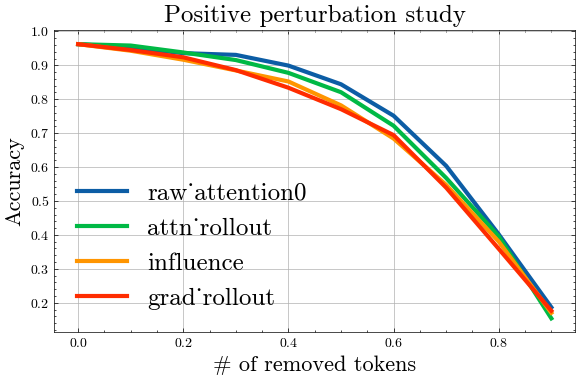

In [45]:
metrics = ['raw_attention0', 'attn_rollout','influence', 'grad_rollout', ]

plt.figure(figsize=(6,4))
for metric in metrics:
    x = pd.read_pickle(f"data/results/vit_{metric}_perturbation_positive.pkl")
    auc = np.trapz(x.values, x.index)

    print(f"{metric} - AUC = {auc}")
    plt.plot(x, label = metric, linewidth = 3)

plt.grid()
plt.title("Positive perturbation study", fontsize = 18)
plt.ylabel("Accuracy", fontsize = 16)
plt.xlabel("# of removed tokens", fontsize = 16)
plt.legend(fontsize = 18)
plt.tight_layout()